# TP : SGD théorie vs. pratique

Avant de commencer, voici quelques instructions et conseils:

- Ce notebook peut s'exécuter au choix avec `jupyter notebook` ou `jupyter lab`. Je vous conseille l'utilisation de `jupyter lab` car il me semble qu'il gère mieux l'affichage des symboles et formules mathématiques que contient l'énoncé.
- Le TP est à rendre le **Dimanche 6 Novembre, 21h00, au plus tard**. Tout retard sera sanctionné.
- Vous serez évalués sur la qualité de votre code et de vos **commentaires**.
- Prenez garde au fait que, durant votre rédaction, vos résultats seront certainement soumis à de l'aléatoire. De plus, il est probable que vous ayez exécuté des cellules dans le désordre. Or, lors de ma correction, j'exécuterai votre notebook une seule fois, dans l'ordre. Ainsi, afin d'assurer que vos résultats correspondent à ceux que je verrai, je vous invite **très fortement** à exécuter une fois pour toutes votre notebook, avec `Kernel > Restart and Run all`, avant de rendre votre copie.
- Certaines des cellules de ce notebook contiennent du code que je souhaite ne pas voir modifiées. Pour cela, je les ai rendues non modifiables. Ne vous inquiétez donc pas de voir que vous ne pouvez pas écrire/modifier certaines cellules.
- Vous devriez utiliser jupyter lab avec une version > 3.0.
- Modalités pour rendre le TP:
  - Enregistrer votre fichier .ipynb avec votre nom de famille: `NOMDEFAMILLE.ipynb`. 
  - Envoyer le fichier par mail à l'adresse `garrigos@lpsm.paris`. 
  - L'objet de l'email doit être `[OPTML TP] NOMDEFAMILLE`.
  - Si vous êtes deux, mettez vos deux noms de famille `NOM1_NOM2`

## Introduction

Dans ce TP, le but est de mettre en lumière diverses propriétés de l'algorithme SGD vues en cours.
L'objectif ici est d'étudier le comportement de SGD sur un exemple *simple*, et de regarder si les bornes que l'on a vu en cours sont pertinentes (spoiler: oui). On va notamment s'intéresser à l'influence de la taille du batch et du choix du pas. Ici le *sampling sera uniforme*.

### Commandes utiles

In [1]:
import numpy as np
from numpy.linalg import norm, svd
from numpy.random import randn, randint
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=0) # Seed for np.random

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."



Voici quelques commandes python dont vous pourrez avoir besoin:

| | |
|-|-|
|`randn(m,n)`| Génère une matrice aléatoire dans $\mathcal{M}_{m,n}(\mathbb{R})$ |
| `np.zeros((m,n))` | Génère une matrice nulle dans $\mathcal{M}_{m,n}(\mathbb{R})$ |
| `np.ones((m,n))` | Génère une matrice remplie de $1$ dans $\mathcal{M}_{m,n}(\mathbb{R})$ |
| `A.T` | Transposée de la matrice `A` |
| `A@B` | Produit entre deux matrices |
| `norm(A,2)` | Plus grande valeur singulière / Norme subordonnée de `A` : $\sigma_{max}(A)$ |
| `norm(x)` | Norme Euclidienne du vecteur `x` |
| `a = []` | Définit la liste vide `a` |
| `a.append(18)` | Rajoute `18` à la fin de la liste `a` |
| `len(a)` | Renvoie la longueur de la liste `a`|

Voici également un prototype de graphique, que vous pourrez adapter par la suite si vous voulez tracer des courbes:

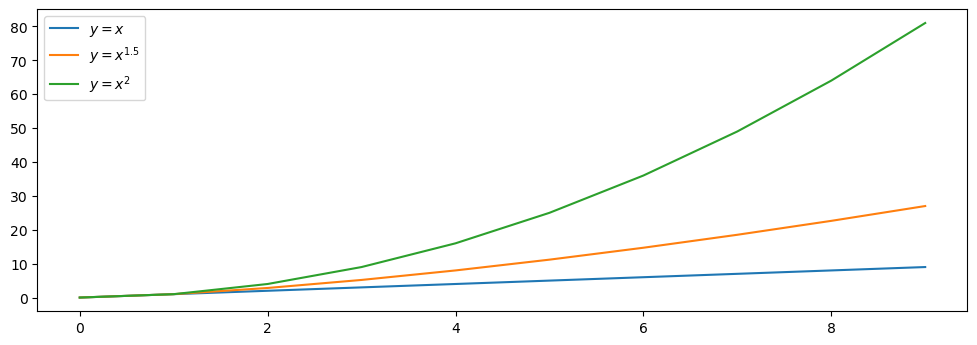

In [2]:
xaxis = np.arange(10)
yaxis_1 = xaxis
yaxis_2 = xaxis**1.5
yaxis_3 = xaxis**2
_ = plt.figure(dpi=100, figsize=(12, 4))
_ = plt.plot(xaxis, yaxis_1)
_ = plt.plot(xaxis, yaxis_2)
_ = plt.plot(xaxis, yaxis_3)
#_ = plt.yscale("log") # Pour avoir une échelle logarithmique en y
_ = plt.legend(['$y=x$','$y=x^{1.5}$','$y=x^2$'])

### Définition du problème

On s'intéresse ici à la minimisation d'une fonction logistique (régularisée):

$$ f(w) = \frac{\mu}{2} \Vert w \Vert^2 + \frac{1}{m} \sum\limits_{i=1}^m \ln \left( 1 + e^{y_i \langle \phi_i, w \rangle} \right), $$

où $\phi_i \in \mathbb{R}^n$, $y_i \in \{\pm 1 \}$ et $\mu >0$. Par la suite, pour plus de lisibilité on notera dans le code `nb_data` (le nombre de données) au lieu de $m$, et `nb_features` (la dimensionalité des données ou de leur features) au lieu de $n$.

**Dans toute la suite**, et à moins que le contraire soit précisé, tous les vecteurs devront être écrits sous la forme de **vecteurs 1D**  `array([1, 2, 3,...])`. 
A ne pas confondre avec des vecteurs 2D pour lesquels il y a ambiguïté sur le fait qu'ils soient des vecteurs ligne `array([[1, 2, 3, ...]])` ou colonne `array([[1], [2], [3], ...])`.

In [3]:
mu = 0.1

In [4]:
def loss_logistic(A, y, mu, X):
    # X est une suite de vecteurs de la forme (dim_data, nb_points)
    # X peut également être simplement un seul 1D vecteur de forme (dim_data,)
    # La fonction renvoie un vecteur "value" de forme (nb_points,)
    # où chaque composante value[i] vaut f(X[:,i])
    nb_data = A.shape[0]
    dim_data = A.shape[1]
    if X.ndim == 1:
        value = 0
    else:      
        value = np.zeros(X.shape[1])
    for i in range(nb_data):
        r = np.log(1 + np.exp((A[i,:]@X)*y[i]))
        value = value + r 
    return (value/nb_data) + (mu/2)*(np.sum(X*X, axis=0))


### Génération du problème

Définissez $m$=`nb_data=1000`, $n$=`nb_features=100`

Générez un jeu de features alétoires, sous la forme d'une matrice aléatoire $A$ de taille `nb_data`x`nb_features`, et un jeu de labels, sous la forme d'un vecteur $y$ aléatoire de taille `nb_data` à valeurs dans $\{ \pm 1 \}$.

\begin{equation*}
A = 
\begin{pmatrix}
\dots & \phi_1^\top & \dots \\
 & \vdots &  \\
\dots & \phi_m^\top & \dots
\end{pmatrix}
\in \mathcal{M}_{m,n}(\mathbb{R}),
\quad 
y=
\begin{pmatrix}
y_1\\
 \vdots  \\
y_m
\end{pmatrix}
\in \mathbb{R}^m
\end{equation*}

In [5]:
m = 1000
n = 100

In [6]:
import random

y = np.random.choice([-1,1],m)
A = randn(m,n)

In [7]:
y.shape

(1000,)

In [8]:
A.shape

(1000, 100)

## Calcul avec les gradients

### Gradients $\nabla f_i$

Définir une fonction `grad_logistic(A, y, mu, w, i)` qui prend en entrée une matrice de features `A`, un vecteur de labels `y`, le paramètre `mu`, un vecteur `w` dans $\mathbb{R}^n$, et un entier `i` ; et qui renvoie $\nabla f_i(w)$. On rappelle que les features correspondent aux lignes de `A`.

On rappelle si besoin que 

$$ \nabla f_i(w) = \frac{y_i e^{y_i \langle \phi_i, w \rangle}}{1 + e^{y_i \langle \phi_i, w \rangle}} \phi_i + \mu w$$

In [9]:
if A[0,:].all() == A[0,:].T.all():
    print("ok")

ok


In [10]:
import math
def grad_logistic(A, y, mu, w, i):
    phi_t = A[i,:]
    phi = phi_t.T
    expo = math.exp(y[i] * np.dot(phi,w))
    div =  y[i] * expo / (1 + expo )
    return div * phi + mu * w

In [11]:
w = np.random.randint(-50,50,n)
i = 20

grad_i = grad_logistic(A, y, mu, w, i)
grad_i

array([-1.5,  2.8, -0.5, -4.5,  0.2,  4.1,  4. ,  0.8, -1.7, -2.4, -1.2,
        1.4,  0.5, -0.1, -1.4, -4.3, -1. , -2. , -0.1, -2.8, -0.1,  3.4,
       -3.8, -2.4, -0.9,  1.7, -1.5, -2.8, -3.6, -0.9,  0.3, -2.8,  1. ,
       -2.8,  4.8, -1.7, -4.4, -0.5, -5. ,  2. ,  2.3, -0.3,  0.3,  1.7,
        2.7,  2.8,  4.9,  2.3, -3.9,  1. , -4.2, -2.2, -3.9, -0.2,  3.6,
       -0.1, -2.6, -0.1, -1.4, -2.2, -1.5, -1.9, -4.2,  1.4,  4.5,  1.7,
        4.5,  0.5, -3.1, -5. ,  3.5, -1.5, -4.4, -1.5,  1.4, -4.1, -2. ,
       -2.6, -2.9, -2.8, -2.2, -0.8,  4.6, -4.1, -1.5,  1.4, -1.3,  2.9,
       -3.9,  1.8, -3.7,  1. , -2.8,  1.7,  4.2, -4.8,  2.2, -4.3, -0.1,
       -3.6])

In [12]:
# do not delete

### Mini-batches

Définir une fonction `grad_batch_logistic(A, y, mu, w, batch)` qui prend en entrée une matrice de features `A`, un vecteur de labels `y`, le paramètre $\mu$,  un vecteur `w` dans $\mathbb{R}^n$, et une *liste* `batch` d'entiers ; et qui renvoie $$\frac{1}{\vert batch \vert}\sum\limits_{i \in batch}\nabla f_i(w).$$

On rappelle que l'on peut faire une boucle `for` sur une liste donnée : `for i in nom_de_la_liste:` ; et que la longueur d'une liste s'obtient avec `len(nom_de_la_liste)`

In [13]:
def grad_batch_logistic(A, y, mu, w, batch):
    sum = 0
    batch_div = 1 / len(batch)
    for i in batch : 
        sum += grad_logistic(A, y, mu, w, i)
    return batch_div * sum   

In [14]:
# do not delete

### Constantes de Lipschitz

Etant donné un indice $i \in \{1, \dots, m \}$, êtes vous capables de calculer $L_i$, la constante de Lipschitz de $\nabla f_i$?
Pour répondre à cette question, vous pourrez consulter le TD au sujet du calcul de la constante de Lipschitz pour une fonction logistique. Par ailleurs vous ferez **très attention** au fait qu'ici $f_i$ est la **somme** entre une fonction logistique et une fonction quadratique (le problème est régularisé (Ridge regression)).
*Notez que je n'attend pas de réponse de votre part ici, mais vous allez devoir implémenter votre réponse juste après.*

Même question, cette fois-ci avec $L$, la constante de Lipschitz de $\nabla f$?

**Attention:** comme indiqué en cours, ces constantes sont **très importantes** pour contrôler le comportement de SGD. Si vous faites une erreur à ce niveau, vous risquez d'avoir des résultats incompréhensibles plus tard dans le TP, que vous aurez du mal à débugger.


### Constante de smoothness par rapport au sampling

Définir une fonction `Lipschitz_batch(A, mu, batch_size)` qui prend en entrée une matrice de features `A`, la constante `mu`, une taille de batch `batch_size` ; et qui renvoie $\mathcal{L}$, la constante de smoothness par rapport au sampling vu en cours. On rappelle si besoin que dans notre cadre de mini-batch sampling, on  peut prendre (avec `m=nb_data` et `b=batch_size`):
$$\mathcal{L} = \frac{(b-1)m}{(m-1)b}  L + \frac{m-b}{b(m-1)} L_{max},$$ 
où $L_{max} = \max_i L_i$, $L_i = Lip(\nabla f_i)$ et $L = Lip(\nabla f)$. 

In [15]:
from numpy.linalg import norm
# on pensera à ne pas oublier mu
def Lipschitz_batch(A, mu, batch_size):

    Li_list = []
    m = A.shape[0]
    for i in range(0,m):
        Li_list.append((np.linalg.norm(A[i,:].T,2))**2/4 + mu)

    L_max = np.max(Li_list)
    L = (np.linalg.norm(A.T,2))**2/(4*m) + mu

    val_1 = (((batch_size-1) * m) / ((m-1) * batch_size)) * L
    val_2 = ((m-batch_size) / ((m-1) * batch_size)) * L_max

    L_rond = val_1 + val_2

    return L_rond

In [16]:
L_rond = Lipschitz_batch(A, mu, 5)
print(L_rond)

8.210334169973375


In [17]:
# do not delete

## SGD

### Implémentation de l'algorithme

Définir une fonction `SGD(A, b, mu, iter_max, batch_size, stepsize_factor, starting_point)` qui applique l'algorithme du gradient stochastique au problème de régréssion logistique présenté au début de cette section:
- Le pas de l'algorithme sera constant, et égal à `stepsize_factor`$/\mathcal{L}$.
- A chaque itération, on tirera au hasard et uniformément une liste de taille `batch_size` parmi $\{0,\cdots,m-1\}$, avec la commande `random.sample(range(m), batch_size)`
- L'algorithme fera `iter_max` itérations.
- L'algorithme commencera avec $w^1$=`starting_point` comme premier itéré.
- L'algorithme renverra deux variables en sortie:
    - Le dernier itéré de la suite (un vecteur 1D) $w^T$, où $T$=`iter_max` 
    - Une matrice `iterates` de taille `nb_features` x `iter_max`, qui contiendra (en colonnes) la suite des vecteurs $w^k$ générés par l'algorithme.

In [18]:
# Taper votre code ici
def SGD(A, y, mu, iter_max, batch_size, stepsize_factor, starting_point):

    stepsize = stepsize_factor / Lipschitz_batch(A, mu, batch_size)
    w = starting_point
    n = A.shape[1]
    m = A.shape[0]
    
    iterates = np.zeros((n ,iter_max ))
    iterates[:, 0] = w
    
    for i in range(1, iter_max): 

        batch = random.sample(range(m), batch_size)
        grad_batch = grad_batch_logistic(A, y, mu, w, batch)
        w -= (stepsize * grad_batch)
        iterates[:, i] = w
    
    return w , iterates

In [19]:
start = 10*np.ones(n)
w , iterates = SGD(A, y, mu, 9, 3, 2, start)

In [20]:
print(w.shape)
print(iterates.shape)

(100,)
(100, 9)


In [21]:
# do not delete

### Solution du problème

Par la suite, on aura besoin d'avoir accès à la solution "exacte" du problème, qu'on notera `w_sol`. 

#### Calcul de la solution

Calculer `w_sol` en utilisant `SGD` avec un batch complet (c'est à dire qu'on fera en fait l'algorithme du gradient!). On prendra un `stepsize_factor` (à vous de le choisir!), `starting_point=np.zeros(2)` et `iter_max` le plus grand possible sans que l'algo ne tourne plus d'une minute.

In [22]:
L = Lipschitz_batch(A, mu, m)

In [23]:
w_sol,iter_sol = SGD(A, y, mu, 100, m,1.5, start)

In [24]:
w_sol.shape

(100,)

#### Vérification

Assurez-vous que `w_sol` est bien un minimiseur (et donc que votre algorithme marche à peu près) en vérifiant que $\nabla f(w_{sol}) \simeq 0$. Vous pourrez calculer astucieusement $\nabla f$ en utilisant la fonction `grad_batch_logistic`

In [25]:
batch = [i for i in range(0,m)]
grad_sol = grad_batch_logistic(A, y, mu, w_sol, batch)
grad_sol

array([-1.44884105e-17, -1.99840144e-17, -4.30211422e-18,  1.04360964e-17,
       -1.00475184e-17,  1.04916076e-17, -2.02060590e-17, -3.21964677e-18,
       -1.57374114e-17,  3.33066907e-18, -1.77635684e-18, -1.23234756e-17,
       -7.74380560e-18,  9.15933995e-19, -1.26565425e-17, -2.04281037e-17,
       -6.66133815e-18, -7.57727214e-18, -9.49240686e-18,  2.97539771e-17,
        2.14273044e-17, -1.05609965e-17,  4.77395901e-18,  5.10702591e-18,
        1.21291865e-17, -3.21409566e-17, -6.66133815e-19,  1.15463195e-17,
       -1.06581410e-17,  1.85407245e-17,  9.10382880e-18,  1.55431223e-17,
        3.33066907e-18, -1.01030295e-17,  3.09752224e-17, -2.24611996e-17,
        4.66293670e-18, -1.60982339e-17,  1.26912370e-17,  1.05471187e-18,
        1.08801856e-17, -1.90542027e-17, -2.08721929e-17,  2.07611706e-17,
       -7.82707232e-18, -1.36002321e-17,  1.02695630e-17, -2.77555756e-19,
       -3.18078897e-17, -4.27435864e-18,  1.22124533e-17,  1.15463195e-17,
        2.19824159e-17, -

In [26]:
np.isclose(0,grad_sol)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### Infimum

Définir `inf_f` comme étant l'infimum de $f$, à l'aide de `w_sol` et la fonction `loss_logistic` qu'on vous a donné au début de cette section

In [27]:
inf_f = loss_logistic(A, y, mu, w_sol)
inf_f

0.6588613033205396

In [28]:
# do not delete

### Etude de la convergence en fonction de la batch size

On souhaite comparer la vitesse de convergence de la méthode, en fonction du choix de la taille de batch. Pour cela on va faire tourner l'algorithme dans 3 régimes, correspondant à trois tailles de batch: `1` (le single element sampling), `nb_data` (full batch), et `minibatch=20` (intermédiaire).

#### Run

Utiliser l'algorithme pour chaque taille de batch. Pour chacun d'entre eux on utilisera les mêmes paramètres :`iter_max` $\sim$ 100 (à vous de choisir), `stepsize_factor` = 0.5 et un même point initial aléatoire.

**NB:** on évite de prendre 0 comme point initial car on est dans un cadre assez spécifique où, même si `A` et `y` sont aléatoires, la solution du problème est toujours concentrée autour de 0. Ce serait tricher! De même on évite de prendre un vecteur avec de petites coordonnées (comme ceux obtenus par une loi gaussienne de variance 1). Pour éviter cela on peut multiplier ledit vecteur par un facteur 10 par exemple.

In [29]:
iter_max = 300

single_batch = SGD(A, y, mu, iter_max, 1, 0.5, 10*np.ones(n))
full_batch   = SGD(A, y, mu, iter_max, m, 0.5,  10*np.ones(n))
minibatch    = SGD(A, y, mu, iter_max, 20, 0.5, 10*np.ones(n))


#### Visualiser les valeurs $f(x^k)$

En utilisant la liste des itérés produite par SGD, et la fonction `loss_logistic`, calculer un vecteur contenant les valeurs de $f(x^k) - \inf f$, pour chacun des trois régimes.

Ensuite, tracer $f(x^k) - \inf f$ pour chacun des trois régimes. Pour tracer une courbe il suffira d'utiliser `plt.plot(iterations, vecteur_des_valeurs)`, avec `iterations=np.arange(iter_max)`.

In [30]:
# Taper votre code ici
iterations = np.arange(iter_max)

def conv(regime,iter_max): 
    iterates = regime[1]
    conv_ite = np.zeros(iter_max)
    for i in range(iter_max): 
        conv_ite[i] = loss_logistic(A,y,mu,iterates[:,i]) - inf_f

    return conv_ite


In [31]:
v_single_batch = conv(single_batch,iter_max)
v_full_batch = conv(full_batch,iter_max)
v_minibatch = conv(minibatch,iter_max)

<function matplotlib.pyplot.show(close=None, block=None)>

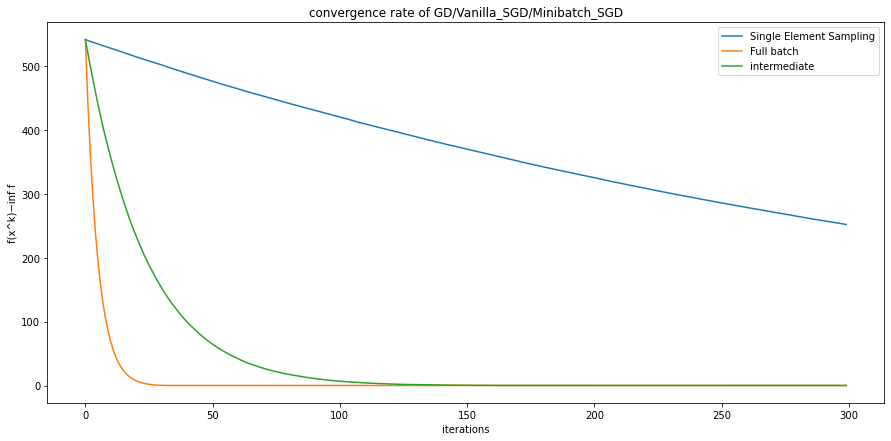

In [32]:
fig = plt.figure(figsize=(15, 7))

plt.plot(iterations, v_single_batch, label = "Single Element Sampling")
plt.plot(iterations, v_full_batch, label = "Full batch")
plt.plot(iterations, v_minibatch, label = "intermediate" )

plt.legend(loc="upper right")
plt.ylabel('f(x^k)−inf f')
plt.xlabel('iterations')
plt.title('convergence rate of GD/Vanilla_SGD/Minibatch_SGD')
plt.show

#### Commentaire

Comparer les courbes que vous avez obtenues, et commentez les résultats.

*Votre commentaire ici:* 


Tout d'abord, il est nécéssaire de préciser que f est ***fortement convexe***. En effet $$ f = g + \frac{\mu}{2} \Vert .\Vert^2 $$
avec :
  $$ g(w) = \frac{1}{m} \sum\limits_{i=1}^m \ln \left( 1 + e^{y_i \langle \phi_i, w \rangle} \right) $$ g étant convexe puisque sa hessienne $\nabla^2 g(w) = \frac{1}{4m}\Vert \phi||^2\\ $ est positive. 


Ainsi la fonction f étant fortement convexe et le stepsize bien choisi $lambda = \frac{1}{\mathcal{L}}$, il n'est pas étonnant que la quantité $f(x^k) - \inf f$ converge le plus vite vers 0 pour l'algorithme SGD Full batch (donc l'algorithme GD classique).

En ce qui concerne single element sampling et mini batch, on sait que plus la variance à la solution est petite, le mieux se comportera notre algorithm SGD.

Or, on sait que la méthode mini batch de SGD permet de réduire la variance du gradient et donc de notre problème, ce qui explique pourquoi le single element sampling de SGD nécessite un nombre beaucoup plus important d'itérations pour s'approcher de la solution.
Tout de même on sait que que ce soit pour mini-batch ou single element sampling, **aucune des deux méthode ne converge exactement vers la solution**.


En effet, on observe 2 régimes de convergence pour minibatch (une première phase rapide pendant laquelle l'algo approche la solution en `≈ 100 itérations `suivit par une phase de stagnation sans jamais atteindre inf f).
Même si on a l'impression que la quantité $f(x^k) - \inf f$ ≈ 0 sur le graphe, lorsque l'on affiche la suite des itérées on voit bien que ce n'est jamais le cas.

Enfin, on voit sur le graphe que le nombre d'itérations nécessaires pour que la quantité $f(x^k) - \inf f$ converge vers 0 est plus importante pour le `batch_size = 20 ( ≈ 100 itérations)` et pour `batch_size = 1` que pour `batch_size = nb_data ( ≈ 25 itérations)` ce qui n'est pas étonnant puisque la variance à la solution augmente à mesure que la taille du batch diminue.  

#### On recommence

A la question précédente on a tracé des courbes de $f(x^k) - \inf f$. Or comparer ces courbes en tout $k$ est injuste : une itération pour la méthode avec un full batch coute `nb_data` fois plus cher qu'une itération avec un batch de taille 1.

Reprendre donc les questions précédentes, mais cette fois-ci on va pour chaque algorithme allouer un nombre différent d'*itérations*, de telle façon que chaque algorithme ne passe que `2` fois sur les données, exactement (autrement dit, `2000` accès au gradients). 
On tracera alors, pour chaque régime, une courbe *constante par morceaux*: le vecteur des abscisses `iterations` devra être modifié en fonction de la taille du batch!

In [56]:
# Une fonction qui pourra vous être utile pour transformer des vecteurs en vecteurs constants par morceaux
def dilater(x, factor):
    # input: x, of size (n,)
    # output: y, of size (n*factor,) 
    # dilates x by making it longer and constant by parts
    y = np.zeros(x.shape[0]*factor)
    for k in range(x.shape[0]):
        y[k*factor:(k+1)*factor] = x[k]
    return y

<function matplotlib.pyplot.show(close=None, block=None)>

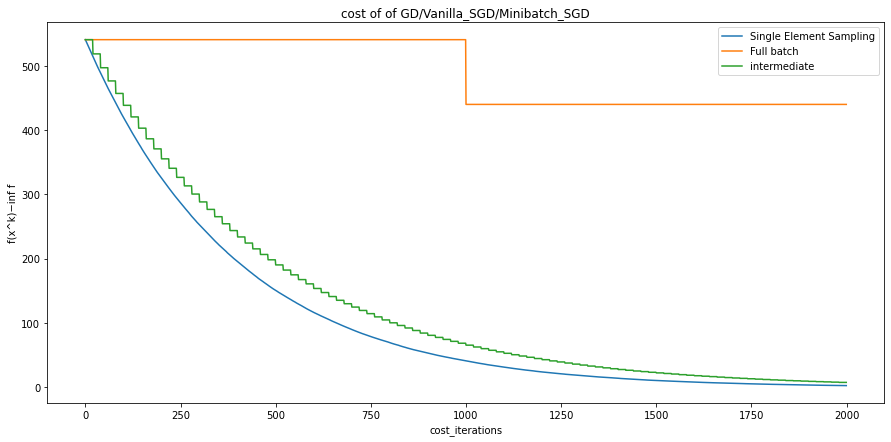

In [57]:
d_single_batch = SGD(A, y, mu, 2000, 1, 0.5, 10*np.ones(n))
d_full_batch   = SGD(A, y, mu, 2, 1000, 0.5,  10*np.ones(n))
d_minibatch    = SGD(A, y, mu, 100, 20, 0.5, 10*np.ones(n))

di_single_batch = conv(d_single_batch,2000)
di_full_batch = conv(d_full_batch,2)
di_minibatch = conv(d_minibatch,100)

#dilat_single_batch = dilater(di_single_batch , 1)
dilat_full_batch = dilater(di_full_batch, 1000)
dilat_minibatch = dilater(di_minibatch, 20)

plt.figure(figsize=(15, 7))
plt.plot(np.arange(2000), di_single_batch,  label = "Single Element Sampling")
plt.plot(np.arange(2000), dilat_full_batch, label = "Full batch")
plt.plot(np.arange(2000), dilat_minibatch, label = "intermediate")
plt.legend(loc="upper right")
plt.ylabel('f(x^k)−inf f')
plt.xlabel('cost_iterations')
plt.title("cost of of GD/Vanilla_SGD/Minibatch_SGD")
plt.show

In [58]:
L_rond = Lipschitz_batch(A, mu, 20)
L_max = Lipschitz_batch(A, mu, 1)
L = Lipschitz_batch(A, mu, 1000)

com_cost_gd = L * m
com_cost_sgd = L_max 
com_cost_minibatch = L_rond * 20

print("\n GD:" , com_cost_gd, "\n SGD:",com_cost_sgd, "\n Minibatch:" ,com_cost_minibatch)


 GD: 511.8819949874895 
 SGD: 39.15888562720307 
 Minibatch: 48.14961543485616


Commenter à nouveau les courbes que vous obtenez, en faisant le lien notamment avec les résultats du cours.

Pensez-vous que le problème que l'on résoud est "facile"?

Avec quel (hyper)paramètre pourriez-vous jouer pour changer la difficulté du problème?


*Votre commentaire ici :* 

#### Commentaire bis

**Commenter à nouveau les courbes que vous obtenez, en faisant le lien notamment avec les résultats du cours.** 

On voit qu'une itération de Full batch est 1000 fois plus coûteuse (mais nous avance plus) qu'une itération de vanilla SGD et 100 fois plus coûteuse qu'une itération de minibatch (batch_size = 20). Donc même si dans le graphe précédent GD classique arrive avec moins d'itérations à la solution, celui-ci est beaucoup plus coûteux que les 2 autres méthodes de SGD.

Ainsi, malgrès son efficacité par itération, si on ne nous autorise à faire que 2000 accès au gradients (donc seulement 2 itérations), son accès coûteux aux données nous limite à une solution qui est très loin de l'inf de f ($f(x^k) - \inf f ≈  400$). 

En ce qui concerne mini-batch, une unique itération est plus efficace que plusieurs étapes de vanilla SGD.Ainsi, même si ce dernier est moins coûteux, mini-batch nous permet d'avoir une convergence assez rapide (d'après le premier graphe) avec un nombre d'itérations raisonnable et beaucoup moins coûteux que GD et se rapproche plutôt du coût de vanilla SGD.


Si on mesure la complexité avec $||x^k -x^*||$  ou $E[||x^k − x^∗||^2]$: 
ce qu'on chercherait dans cette partie serait la méthode qui nous donne le meilleur compromis coût/complexité on pourrait alors mesurer nb_accès_données*complexité: 

or la compléxité de:

GD = $\frac{L}{\mu} log(\frac{1}{\epsilon})$

vanilla SGD = $\frac{Lmax}{\mu} log(\frac{1}{\epsilon})$

Minibatch = $\frac{\mathcal{L}}{\mu} log(\frac{1}{\epsilon})$

On a alors que:

-Vanilla SGD est plus efficace que GD lorsque $mL >> Lmax$

-vanilla SGD est plus efficace que minibatch SGD lorsque $Lmax >> \mathcal{L}*batchsize$

donc finalement on observerait plutôt: 

GD: $m * L ≈ 512$

SGD vanilla:  $ 1 * Lmax ≈ 40$ 

minibatch:  $20 * \mathcal{L} ≈ 48$

On voit ici que $mL=512 >> Lmax=40$  mais $20*\mathcal{L}=48$ n'est pas très très grand par rapport à $Lmax=40$ 

Ceci reflète donc bien le résultat du cours selon lequel mini-batch nous offre un bon compromis entre coût et efficacité

**Pensez-vous que le problème que l'on résoud est "facile"?** 

Un problème est **facile** si toutes les fonctions $f_i$ se ressemblent ainsi les constantes de lipschitz $L_i = Lip(\nabla f_i)$  sont les mêmes et qu'elles sont toutes ≈  $L = Lip(\nabla f)$. De plus, si le problème est facile, $L= \mathcal{L}$.

Notons `listLi`, la liste des constantes de lipschitz des $ f_i$. 
Dans notre cas, on a $max(listLi) ≈ 40 $ et  $min(listLi) ≈ 15$ , ainsi, on se retrouve avec de valeurs $L_i$ qui tournent autour de 15 et d'autres qui tournent autour de valeurs beaucoup plus grandes. De plus, on a $L ≈ 0.51 ≠ \mathcal{L} ≈ 8.2$ ce qui laisse penser que notre problème est relativement difficile.

**Avec quel (hyper)paramètre pourriez-vous jouer pour changer la difficulté du problème?**

Plus un problème est facile plus on peut prendre des pas plus grands, plus il est difficile, plus on doit prendre un pas petit.
Ainsi, ici on pourrait jouer avec l'(hyper)paramètre 	$\lambda$ correspondant au **stepsize** de l'algorithme pour changer la difficulté du problème en prenant un plus petit pas.

## Visualisation de la variance de SGD

On va maintenant essayer de visualiser la trajectoires des *itérés* de la suite générée par SGD dans le plan. Ci-dessous, une fonction `plot_levelset` qui permet de tracer les itérés d'une suite, ainsi que d'afficher les courbes de niveau de la fonction $f$. 

**NB:** ne pas modifier le code ci-dessous

**NB:** Si vous n'avez pas respéecté la consigne d'écrire les vecteurs comme des 1D-arrays, vous aurez dans cette section des problèmes.

In [36]:
def get_box(X, crop=None, option=None):
    # Given a 2D sequence X of size 2 x nb_iter
    # returns a box=[mx,Mx,my,mY] in which it belongs (for display purposes)
    if option == "square":
        min_x = np.min(X); max_x = np.max(X); min_y = min_x; max_y = max_x;
    else:
        min_x = np.min(X[0,:]); max_x = np.max(X[0,:]); min_y = np.min(X[1,:]); max_y = np.max(X[1,:]);
    if crop is None: crop = 0.31
    mx = min_x - crop * (max_x-min_x); Mx = max_x + crop * (max_x-min_x);
    my = min_y - crop * (max_y-min_y); My = max_y + crop * (max_y-min_y);
    return [mx, Mx, my, My]

def plot_levelset(A, b, mu, iterates, box=None):
    # Given the function f(A,b) et a 2D sequence of points (X,Y)
    # plots the contour of the function and the sequence of iterates of size 2 x nb_iter
    # We do it within a box=[mx,Mx,my,mY]
    if box is None: box = get_box(iterates)
    [mx, Mx, my, My] = box
    x = np.linspace(mx, Mx, 50)
    y = np.linspace(my, My, 50)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid = np.zeros((2,50*50))
    grid[0,:] = X_grid.reshape(50*50)
    grid[1,:] = Y_grid.reshape(50*50)
    Z = loss_logistic(A, b, mu, grid)
    Z_grid = Z.reshape(50,50)
    _=plt.contour(X_grid, Y_grid, Z_grid, colors='black') # level sets
    _=plt.scatter(iterates[0,0],iterates[1,0], facecolors='none', edgecolors='r', s=100) # strating point
    _=plt.scatter(iterates[0,:],iterates[1,:], facecolors='none', edgecolors='b') # trajectory
    plt.gca().set_aspect('equal', adjustable='box')
    

def plot_solution(w_sol, radius=None):
    if radius is None: radius=0
    ball = plt.Circle((w_sol[0], w_sol[1]), radius=radius, color='r', fill=False)
    plt.gcf().gca().add_artist(ball) # the circle
    _=plt.scatter(w_sol[0], w_sol[1], marker='*', edgecolors='r', s=100) # solution


### Redéfinition du problème

Ici, on va un peu changer les paramètres du problème. 

Générer à nouveau, comme au début du TP, un jeu de données `A`, `y` avec $n$=`nb_data = 20`, $m$=`nb_features=2`. On gardera `mu=0.1`. 

Etant donné ces nouvelles données, vous calculerez à nouveau `w_sol`, la solution du problème associé, à l'aide de SGD.

In [37]:
m2 = 20 #(nb_features)
n2 = 2 #(nb_data)

y2 = np.random.choice([-1,1],m2)
A2 = randn(m2,n2)

In [38]:
y2.shape

(20,)

In [39]:
A2.shape

(20, 2)

In [40]:
w_sol,iter_sol = SGD(A2, y2, mu, 100, m2,1, 10*np.ones(n2))

In [41]:
batch2 = [i for i in range(0,m2)]
grad_batch_logistic(A2, y2, mu, w_sol, batch2) 

array([3.60822483e-17, 9.54097912e-18])

In [42]:
# do not delete

### Visualisation des itérés

#### Run avec le nouveau problème 2D

Faire tourner l'algorithme SGD avec les paramètres de votre choix, afin de génrérer une suite d'itérés. Utiliser la fonction `plot_levelset(A, y, mu, iterates)` pour visualiser la suite des itérés qu'elle génère. 
On pourra également utiliser `plot_solution(w_sol)` pour superposer la solution du problème aux itérés.
Pour avoir une "jolie" trajectore, je conseille de prendre un point de départ à distance raisonable de l'origine.

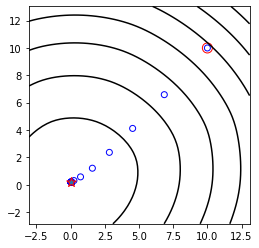

In [43]:
#Classic gradient descent avec pas=
plot_levelset(A2, y2, mu, iter_sol)
plot_solution(w_sol)

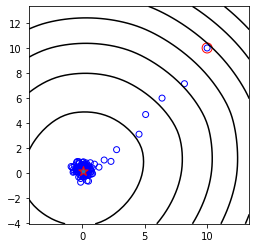

In [44]:
#minibatch avec batchsize = 5  avec pas=1
w_mini2,iter_mini2 = SGD(A2, y2, mu, 100, 5, 1 , 10*np.ones(n2))
plot_levelset(A2, y2, mu, iter_mini2)
plot_solution(w_sol)

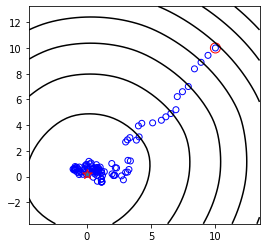

In [45]:
#SGD vanilla avec pas=1
w_single2,iter_single2 = SGD(A2, y2, mu, 100, 1, 1 , 10*np.ones(n2))
plot_levelset(A2, y2, mu, iter_single2)
plot_solution(w_sol)

#### Changements de paramètres

Reprenez la question précédente, en faisant cette fois-ci varier les paramètres de l'algorithme: taille du batch et `stepsize_factor`. 

Décrivez ce que vous observez.

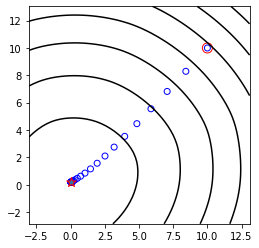

In [46]:
#Classic sgd avec pas=0.5 
w_full_3,iter_full_3 = SGD(A2, y2, mu, 100, m2, 0.5 , 10*np.ones(n2))
plot_levelset(A2, y2, mu, iter_full_3)
plot_solution(w_sol)

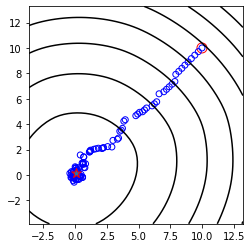

In [47]:
# Vanilla SGD avec pas = 0.5
w_single_3,iter_single_3 = SGD(A2, y2, mu, 100, 1, 0.5 , 10*np.ones(n2))
plot_levelset(A2, y2, mu, iter_single_3)
plot_solution(w_sol)

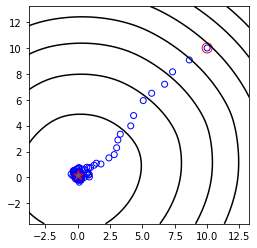

In [48]:
#minibatch avec batchsize=5 et pas =0.5
w_mini3,iter_mini3 = SGD(A2, y2, mu, 100, 5, 0.5 , 10*np.ones(n2))
plot_levelset(A2, y2, mu, iter_mini3)
plot_solution(w_sol)

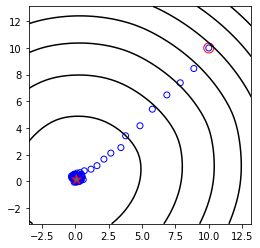

In [49]:
#minibatch avec batchsize=10 et pas =0.5
w_mini4,iter_mini4 = SGD(A2, y2, mu, 100, 10, 0.5 , 10*np.ones(n2))
plot_levelset(A2, y2, mu, iter_mini4)
plot_solution(w_sol)

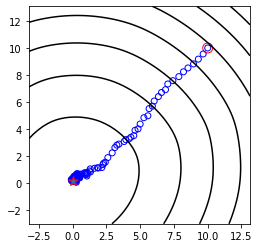

In [50]:
#minibatch avec batchsize=5 et pas =0.2
w_mini5,iter_mini5 = SGD(A2, y2, mu, 100, 5, 0.2 , 10*np.ones(n2))
plot_levelset(A2, y2, mu, iter_mini5)
plot_solution(w_sol)

*Vos commentaires:* 
- GD converge exactement vers la solution 
- Vanilla SGD a une trajectoire très bruitée et n'est pas du stable autour de la solution.
- Minibatch se rapproche de la solution avec moins d'itérations que vanilla SGD, avec une trajectoire un peu plus stable mais qui se dégrade lorsqu'elle approche la solution. En prenant un pas plus petit, minibatch a besoin de plus d'itérations pour approcher la solution mais la zone très bruitée autour de la solution devient plus petite. En prenant un batch plus grand on a une trajectoire plus stable et avec un plus petit bruit autour de la solution.

### Rayon de convergence

D'après le cours, on sait qu'après un grand nombre d'itérations, la suite va (en moyenne) être contenue dans une boule centrée en `w_sol` et de rayon `r`, donné par

$$ r = \sqrt{\frac{2\sigma^2\lambda}{\mu}} \quad \text{ où } \sigma^2 = \mathbb{E}_S\left[ \Vert \nabla f_S(w_{sol}) \Vert^2 \right] \text{ et } \lambda \text{ est le pas de l'algorithme}. $$

Par ailleurs, il est possible de montrer que  

$$\sigma^2 = \frac{m-b}{b(m-1)} \frac{1}{m}\sum\limits_{i=1}^m \Vert \nabla f_i(w_{sol}) \Vert^2,$$ 

où ici  $b$ est la taille du batch et $m$ le nombre de données (cf. [Proposition 3.10.iii ici](https://arxiv.org/pdf/1901.09401.pdf)).

#### Calcul du rayon

Définir une fonction `expected_radius(A, y, mu, w_sol, batch_size, stepsize_factor)` qui renvoie la valeur de ce rayon $r$ en fonction des paramètres du problème et de l'algorithme.

In [51]:
def expected_radius(A, y, mu, w_sol, batch_size, stepsize_factor):
    m2 = A.shape[0]
    sum_grad = 0
    radius = 0
    stepsize =  stepsize_factor / Lipschitz_batch(A, mu, batch_size)

    for i in range(m2):
        grad_i = grad_logistic(A, y, mu, w_sol, i)
        sum_grad += np.linalg.norm(grad_i, ord=2)**2
    
    sig = ((m2 - batch_size) / (m2 * batch_size * (m2 - 1))) * sum_grad
    radius = np.sqrt((2 * sig * stepsize)/mu)
    return radius


In [52]:
# do not erase

#### Visualiser le rayon

Tracer les itérés de l'algorithme tel que précédemment en utilisant en plus cette fois-ci la fonction `plot_solution(w_sol, rayon)` qui va tracer un cercle de centre `w_sol` et de rayon `rayon`. Vous calculerez le rayon avec la fonction de la question précédente. 

Que pensez-vous du résultat? Est-ce que le résultat est fidèle à ce que prédit la théorie? Essayez d'être critiques.

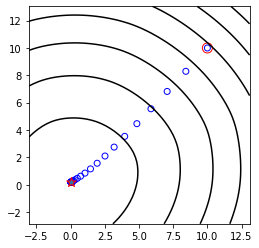

In [53]:
#Classic sgd avec pas=0.5 
rayon = expected_radius(A2, y2, mu, w_sol, m2, 0.5)
plot_levelset(A2, y2, mu, iter_full_3)
plot_solution(w_sol,rayon)

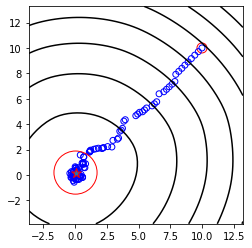

In [54]:
# Vanilla SGD avec pas = 0.5
rayon = expected_radius(A2, y2, mu, w_sol, 1, 0.5)
plot_levelset(A2, y2, mu, iter_single_3)
plot_solution(w_sol,rayon)

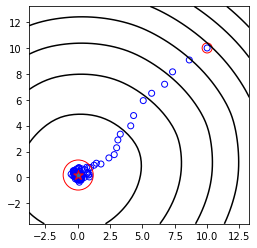

In [55]:
#minibatch avec batchsize=5 et pas =0.5
rayon = expected_radius(A2, y2, mu, w_sol, 5, 0.5)
plot_levelset(A2, y2, mu, iter_mini3)
plot_solution(w_sol,rayon)

Pour **SGD avec Full batch**, donc GD classique, on voit bien que la trajectoire tracée n'est pas perturbée par du bruit et se dirige donc directement vers la solution du problème de minimisation en peu d'itérations.
GD étant une méthode de descente sans prises de risques,le résultat obtenu est bien fidèle à ce que prédit la théorie.

Pour l'algorithme SGD avec **single element sampling**,
on observe 2 régimes de convergence sur le schema : convergence rapide en plusieurs itérations vers une boule puis stagnation. D'autre part, on remarque que cette trajectoire ne suit pas une descente droite.

Le fait que la trajectoire suivit soit bruitée et qu'elle prenne parfois différentes directions est justifié par la variance. Cette dernière se traduit par la difference entre le calcul du gradient d'une unique donnée pris en compte dans le calcul de chaque étape de SGD et la véritable moyenne du gradient de toutes les données. 
Cette variance empêche notamment la convergence de cet algorithme vers la solution comme en témoigne la stagnation des itérations de l'algorithme au niveau de la boule centrée autour de la solution x sans pour autant l'atteindre.Ce résultat est donc fidèle à ce que prédit la théorie.

Pour l'algorithme SGD avec **mini-batch**, on peut voir sur le schéma que le nombre d'itérations pour atteindre la boule est moins important que pour vanilla SGD et que la trajectoire suivie est moins sujette à la variance puisque mini batch est une approche visant à réduire la variance de SGD. Ainsi pour cette méthode on sait d'après le cours que plutôt que de calculer le gradient en un seul point, on calcule le gradient sur 20 données ce qui nous permet d'avoir une meilleure estimation du gradient.
Cependant, même si la variance à la solution est réduite, elle est toujours présente ce qui se traduit sur le dessin par une stagnation dans une boule (plus petite que celui pour SGD grâce à la réduction de la variance) centrée autour de la solution, sans jamais atteindre cette dernière.Encore une fois le résultat obtenu est fidèle à ce que prédit la théorie. 


## Fin du devoir 

Vous vous apprêtez à remettre votre devoir ; avant cela pensez à bien relire les instructions en début du document!